In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime #Monday's weekday is 0
from matplotlib import pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn import metrics

#import datasets
train = pd.read_csv('../input/train_subsampled.csv')
#train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
train.head()

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,233020,id3992301,1,2016-04-13 23:51:12,2016-04-14 00:09:58,2,-74.004349,40.721706,-73.951164,40.727596,N,1126
1,63392,id2780455,1,2016-04-26 12:08:44,2016-04-26 12:14:32,1,-73.976555,40.758209,-73.969528,40.758339,N,348
2,173035,id2879664,2,2016-02-25 23:01:59,2016-02-25 23:28:27,1,-74.002937,40.733414,-73.958580,40.674599,N,1588
3,2592,id3557237,1,2016-02-14 15:27:04,2016-02-14 15:54:43,2,-73.874542,40.773891,-73.975082,40.765301,N,1659
4,1447553,id0569772,2,2016-02-17 17:05:10,2016-02-17 17:07:04,3,-73.945671,40.777981,-73.949707,40.772270,N,114



1. **Feature Engineering** - (Rescaling lat and long feats and adding weekday and hour feats)

In [5]:
# build scalers, use both dropoff and pickup locations for this (hence the append)
latitude_scaler = preprocessing.StandardScaler().fit(
        train.dropoff_latitude.append(
                train.pickup_latitude).values.reshape(-1,1))

longitude_scaler = preprocessing.StandardScaler().fit(
        train.dropoff_longitude.append(
                train.pickup_longitude).values.reshape(-1,1))

# Creating three new features: weekday, hour and trip duration and add them to an engineered dataset.
 # Do this inside a function so we don't have to repeat it to the test set
def append_features(dataset):
    #drop some unnecessary columns if they exist
    columns_to_be_dropped = [ i for i in ['Unnamed: 0','id','vendor_id'] if i in dataset.columns]
    dataset_eng = dataset.copy().drop(columns_to_be_dropped, axis=1)
    #Create time features (hour and weekday)
    dataset_eng['pickup_datetime'] = dataset_eng.pickup_datetime.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    dataset_eng['pickup_weekday'] = dataset_eng.pickup_datetime.apply(datetime.weekday)
    dataset_eng['pickup_hour'] = dataset_eng.pickup_datetime.apply(lambda x: x.hour)
    #rescale pickup locations
    dataset_eng['pickup_latitude'] = latitude_scaler.transform(dataset_eng.pickup_latitude.values.reshape(-1,1))
    dataset_eng['pickup_longitude'] = longitude_scaler.transform(dataset_eng.pickup_longitude.values.reshape(-1,1))
    #rescale dropoff locations
    dataset_eng['dropoff_latitude'] = latitude_scaler.transform(dataset_eng.dropoff_latitude.values.reshape(-1,1))
    dataset_eng['dropoff_longitude'] = longitude_scaler.transform(dataset_eng.dropoff_longitude.values.reshape(-1,1))
    #calculate rescaled distance
    dataset_eng['distance'] = np.sqrt( 
                                    (dataset_eng.dropoff_latitude - dataset_eng.pickup_latitude).pow(2) + 
                                    (dataset_eng.dropoff_longitude - dataset_eng.pickup_longitude).pow(2) )
    #the following features only apply for the training set
    if 'dropoff_datetime' in dataset.columns:
        dataset_eng['dropoff_datetime'] = dataset_eng.dropoff_datetime.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    return dataset_eng

In [6]:
train_eng = append_features(train)
test_eng = append_features(test)
train_eng.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_weekday,pickup_hour,distance
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,1.67086,-0.000295,-0.012943,0.000295,0.012943,972.59337,3.045860,13.619200,0.657466
std,1.32013,0.999587,0.949432,1.000423,1.047981,3452.05958,1.954588,6.412242,0.776065
min,0.00000,-302.821969,-96.703465,-302.821776,-96.709061,1.00000,0.000000,0.000000,0.000000
25%,1.00000,-0.112966,-0.403857,-0.109112,-0.438338,396.00000,1.000000,9.000000,0.220990
50%,1.00000,-0.049088,0.076104,-0.035889,0.095415,660.00000,3.000000,14.000000,0.423855
75%,2.00000,0.041044,0.488886,0.068599,0.530581,1073.00000,5.000000,19.000000,0.805739
max,6.00000,44.210738,104.142126,31.103444,68.925167,86366.00000,6.000000,23.000000,64.186085


#### Distribution of trips per duration

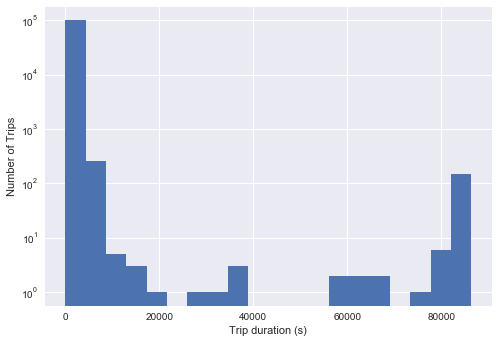

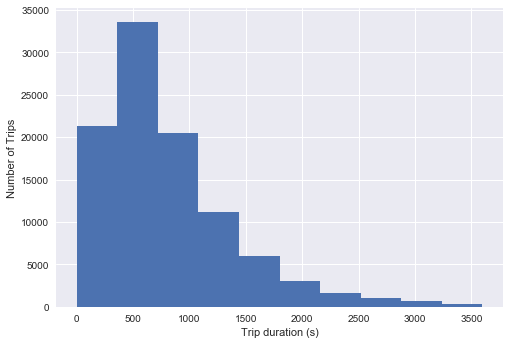

In [7]:
fig1 = train_eng.trip_duration.hist(bins = 20,log=True)
fig1.set_xlabel("Trip duration (s)")
fig1.set_ylabel("Number of Trips")
plt.show()

fig2 = train_eng[train_eng['trip_duration']<3600*1].trip_duration.hist()
fig2.set_xlabel("Trip duration (s)")
fig2.set_ylabel("Number of Trips")
plt.show()

In [8]:
## Function that receives a column of values already grouped by weekday and hour and aggregated, and plots the heat map
def plot_per_weekday_hour(aggregated_data, title = '' ):
    fig = sns.heatmap(aggregated_data.values.reshape((7,24)), cmap = 'jet')
    fig.set_xlabel('Hour')
    fig.set_ylabel('Day of the week')
    fig.set_title(title)
    plt.show()
    
#keep only trips that took less than 1 hour
aggregated_set = train_eng[train_eng['trip_duration']<3600*1].groupby(['pickup_weekday','pickup_hour'])

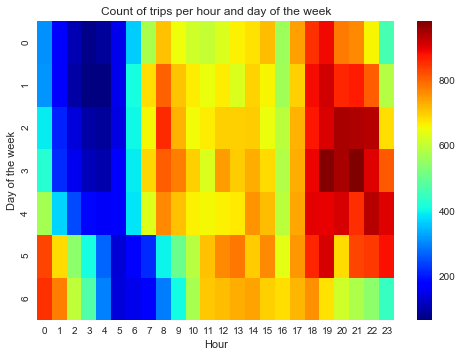

In [9]:

plot_per_weekday_hour(aggregated_set.count().distance, 
                      'Count of trips per hour and day of the week')

Most busy hours are between 17-24h on every day of the week except for Sundays

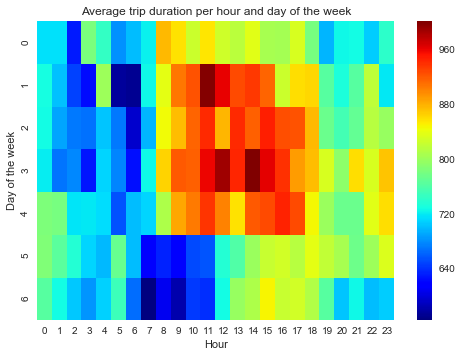

In [10]:
plot_per_weekday_hour(aggregated_set.mean().trip_duration, 
                      'Average trip duration per hour and day of the week')

Longest trips happen from Tuesday to Friday between 10 and 17h (perhaps due to traffic?)

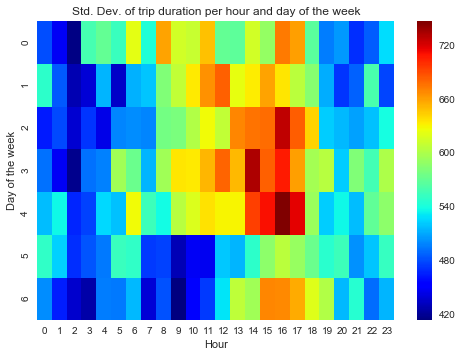

In [11]:
plot_per_weekday_hour(aggregated_set.std().trip_duration, 
                      'Std. Dev. of trip duration per hour and day of the week')

### Clustering by dropoff and pickup positions, hour and day of the week

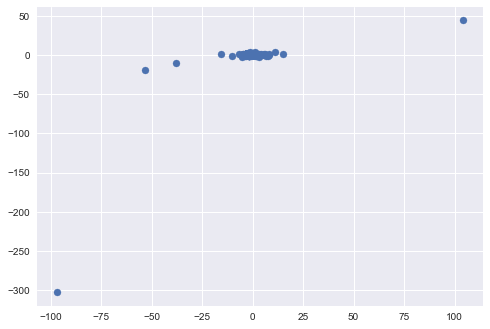

In [12]:
plt.scatter(train_eng.pickup_latitude, train_eng.pickup_longitude)
plt.show()

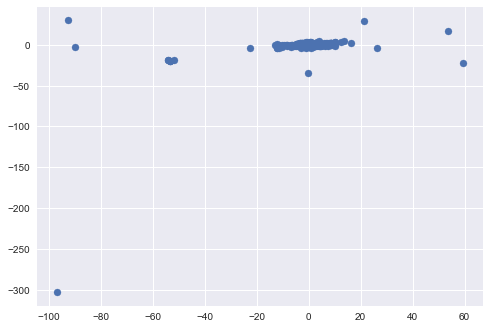

In [13]:
plt.scatter(test_eng.pickup_latitude, test_eng.pickup_longitude)
plt.show()

Some trips are way more distant and take longer than the rest so it won't be possible to obtain an accurate estimate from their neighbors, i.e clustering won't work for these ones...

Perhaps linear regression could be more useful in these cases!

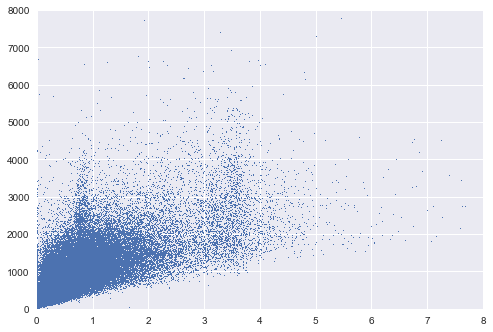

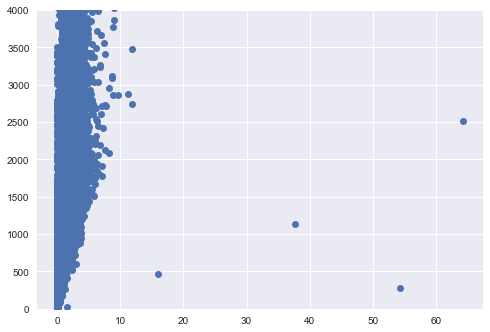

In [14]:
ax = plt.plot(train_eng.distance, train_eng.trip_duration,',')
plt.xlim(0,8)
plt.ylim(0,8000)
plt.show()

ax = plt.plot(train_eng.distance, train_eng.trip_duration,'o')
plt.ylim(0,4000)
plt.show()

##### Keep only interesting trips (the ones that took under 2h)

In [15]:
short_trips = train_eng[(train_eng.trip_duration < 3600*2) & (train_eng.distance < 8)]

In [16]:
short_trips.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_weekday,pickup_hour,distance
count,99798.000000,99798.000000,99798.000000,99798.000000,99798.000000,99798.000000,99798.000000,99798.000000,99798.000000
mean,1.670274,-0.000906,-0.013464,0.000433,0.012711,832.664542,3.045362,13.618940,0.654186
std,1.319346,0.990605,0.888899,0.987537,0.993245,650.440767,1.954669,6.412265,0.710153
min,0.000000,-302.821969,-96.703465,-302.821776,-96.709061,1.000000,0.000000,0.000000,0.000000
25%,1.000000,-0.113014,-0.403473,-0.109112,-0.437625,395.250000,1.000000,9.000000,0.220986
50%,1.000000,-0.049088,0.076433,-0.035889,0.095635,658.000000,3.000000,14.000000,0.423730
75%,2.000000,0.041044,0.488996,0.068551,0.530911,1069.000000,5.000000,19.000000,0.805447
max,6.000000,3.614145,15.088894,4.555448,15.088894,6900.000000,6.000000,23.000000,7.679040


In [17]:
X = short_trips[[
    'pickup_hour', 
    'pickup_weekday',
    'pickup_longitude', 
    'pickup_latitude', 
    'dropoff_longitude', 
    'dropoff_latitude']].values

X = X*[5,100,1,1,1,1]
y = short_trips['trip_duration'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.10, random_state=42)

Mean Absolute Error: 263.8423847695391
R2: 0.6082594761841726


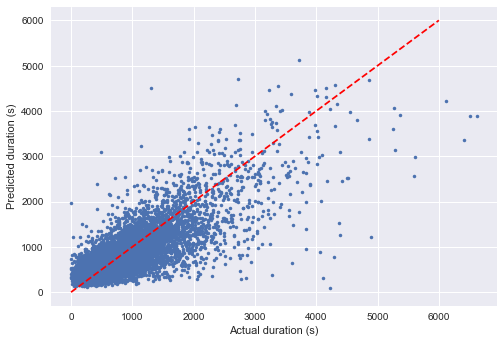

In [18]:
neigh = KNeighborsRegressor(n_neighbors=5, weights = 'distance')
neigh.fit(X_train, y_train)
y_pred = np.int64(neigh.predict(X_test).round())

def evaluate(y_test, y_pred):
    print("Mean Absolute Error: {}".format(metrics.mean_absolute_error(y_test, y_pred)))
    #print("Mean Squared Logarithmic Error: {}".format(metrics.mean_squared_log_error(y_test, y_pred))) # > try later
    print("R2: {}".format(metrics.r2_score(y_test,y_pred)))
    fig2 = plt.plot(y_test,y_pred,'.',[0,6000],[0,6000],'r--')
    plt.xlabel('Actual duration (s)')
    plt.ylabel('Predicted duration (s)')
    plt.show()

evaluate(y_test, y_pred)

Bela m*******